In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import math
import datetime
from bs4 import BeautifulSoup
import pandas as pd 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import time
import requests
import os
%load_ext dotenv
%dotenv
import warnings
warnings.filterwarnings("ignore")

# <font color='purple'>Project Outline

## I. Data scraping from GoodReads.com

Using BeautifulSoup and Selenium to:
   1. Get the list the books that being awarded the GoodReads Choice Award, including book title, and awarded category
   2. Get the details of awarded books, including book title, author, rating, number of reviews, number of ratings and book description

## II. Data cleaning/manipulation

Using Pandas to clean/manipulate data

## III. Data visualizaion

Use Matplotlib to visualize data

# <font color='purple'>Part I - Data scraping from GoodReads.com

### 1. Login to GoodReads

In [115]:
# initialize the webdriver
driver = webdriver.Chrome('./chromedriver')

# get to the sign in page
driver.get('https://www.goodreads.com/ap/signin?openid.return_to=https%3A%2F%2Fwww.goodreads.com%2Fap-handler%2Fregister&prevRID=EJRZAY8ACV30Y171D3FV&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.assoc_handle=amzn_goodreads_web_na&openid.mode=checkid_setup&siteState=7e2f05d4a0d19eb1f36522c4b68af6aahttps%3A%2F%2Fwww.goodreads.com%2Fap%2Fregister%3Flanguage%3Den_US&language=en_US&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&pageId=amzn_goodreads_web_na&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0')

# enter email
driver.find_element(By.ID, 'ap_email').clear()
driver.find_element(By.ID, 'ap_email').send_keys(os.getenv('EMAIL'))

# enter password
driver.find_element(By.ID, 'ap_password').clear()
driver.find_element(By.ID, 'ap_password').send_keys(os.getenv('PASSWORD'))

# click on sign in
driver.find_element(By.ID, 'signInSubmit').click()

### 2. Get the links of the awarded books each year

#### Each year has a page showing all the winning books in groups of category of that year, starting from 2011

The below code is to get all the links of the yearly award page.

In [4]:
# get the choice award links from 2011 to the current year

yearly_awards_urls = {}
start_year = 2011
current_year = datetime.date.today().year
year = start_year

while year < current_year:
    choice_awards =  'https://www.goodreads.com/choiceawards/best-books-'+ str(year) + '?ref=nav_brws_gca'
    yearly_awards_urls[year] = choice_awards
    year += 1
    
for year in yearly_awards_urls:
    print(year, '->', yearly_awards_urls[year])

2011 -> https://www.goodreads.com/choiceawards/best-books-2011?ref=nav_brws_gca
2012 -> https://www.goodreads.com/choiceawards/best-books-2012?ref=nav_brws_gca
2013 -> https://www.goodreads.com/choiceawards/best-books-2013?ref=nav_brws_gca
2014 -> https://www.goodreads.com/choiceawards/best-books-2014?ref=nav_brws_gca
2015 -> https://www.goodreads.com/choiceawards/best-books-2015?ref=nav_brws_gca
2016 -> https://www.goodreads.com/choiceawards/best-books-2016?ref=nav_brws_gca
2017 -> https://www.goodreads.com/choiceawards/best-books-2017?ref=nav_brws_gca
2018 -> https://www.goodreads.com/choiceawards/best-books-2018?ref=nav_brws_gca
2019 -> https://www.goodreads.com/choiceawards/best-books-2019?ref=nav_brws_gca
2020 -> https://www.goodreads.com/choiceawards/best-books-2020?ref=nav_brws_gca
2021 -> https://www.goodreads.com/choiceawards/best-books-2021?ref=nav_brws_gca
2022 -> https://www.goodreads.com/choiceawards/best-books-2022?ref=nav_brws_gca


### 3. Get all the links of each category in each year winnng the choice awards

In [9]:
categoryUrl = []

for year in yearly_awards_urls:
    # head to Choice Awards page 
    driver.get(yearly_awards_urls[year])
    # get the soup of the page
    categories_soup = BeautifulSoup(driver.page_source)
    # select the part having the link of each book category
    links = categories_soup.select('div.category.clearFix a')
    # get the link of each category
    for link in links:
        if link.get('href') != '#':
            categoryUrl.append('https://www.goodreads.com' + link.get('href'))
    time.sleep(3)

In [84]:
# save the all the yearly awards urls to a csv file    
df_urls = pd.DataFrame(categoryUrl, columns=['url']) 
df_urls.to_csv('yearly_awards_url.csv', index=False) 

In [96]:
# read the yearly awards urls file 
yearly_award_urls = pd.read_csv('yearly_awards_url.csv')
yearly_award_urls = yearly_award_urls['url'].tolist()

### 4. Scrap book id, book title, and links direct to book details. 

In [118]:
def get_book_list(url):
    '''
    get a dictionary containing the book id, book title and the book link of all the books listed on the webpage
    '''
    driver.get(url)
    booklist_soup = BeautifulSoup(driver.page_source)
    
    # locate to the section have all the book information
    booklists = booklist_soup.find_all('div', 'resultShown')
    
    books_info= {
        'book_id':[], 
        'award_category':[],
        'title':[],
        'number_of_votes':[],
        'link':[]
    }

    for book in booklists:
        # get book id
        books_info['book_id'].append(book.select('div.js-tooltipTrigger')[0].attrs['data-resource-id'])
        # get award category
        books_info['award_category'].append(url.split('/')[-1].replace('-', ' '))
        # get book title
        books_info['title'].append(book.select('div.js-tooltipTrigger img')[0].attrs['alt'])
        # get number of votes:
        books_info['number_of_votes'].append(int(book.find('strong', 'uitext result').get_text(strip=True).replace('\nvotes', '').replace(',' ,'')))
        # get book link
        books_info['link'].append('https://www.goodreads.com' + book.select('div.js-tooltipTrigger a')[0].get('href'))

    return books_info

In [117]:
awarded_books= {
    'book_id':[], 
    'award_category':[],
    'title':[],
    'number_of_votes':[],
    'link':[]
}

for url in yearly_award_urls:
    book = get_book_list(url)
    awarded_books['book_id'] += book['book_id']
    awarded_books['award_category'] += book['award_category']
    awarded_books['title'] += book['title']
    awarded_books['number_of_votes'] += book['number_of_votes']
    awarded_books['link'] += book['link']    

In [4]:
# save the awarded books to a csv file    
df_awarded_books= pd.DataFrame(awarded_books)
df_awarded_books.to_csv('awarded_books.csv', index=False) 

### 5. Get the details of the book 

In [267]:
def get_book_detail(url):
    
    try:
        driver.get(url)
    except:
        driver.refresh()
        
    bookinfo_soup = BeautifulSoup(driver.page_source)

    bookinfo = bookinfo_soup.find('div', id='topcol')
    
    book_detail = {
        'book_id':[],
        'title':[],
        'author':[],
        'author_link':[],
        'rating':[],
        'number_of_ratings':[],
        'number_of_reviews':[],
        'reviews_link':[],
        'book_description':[]
        }

    try:
        book_detail['book_id'].append(bookinfo.find('div', 'previewButtonContainer').attrs['data-book-id'])
    except:
        book_detail['book_id'].append('N/A')

    try:
        book_detail['title'].append(bookinfo.find('h1', id='bookTitle').getText(strip=True))
    except:
        # save the book link to title if failed to scrape the informaion
        book_detail['title'].append(url)
        
    try:
        book_detail['author'].append(bookinfo.find('a', 'authorName').getText(strip=True))
    except:
        book_detail['author'].append('N/A')

    try:    
        book_detail['author_link'].append(bookinfo.find('a', 'authorName').get('href'))
    except:
        book_detail['author_link'].append('N/A')
    
    try:
        book_detail['rating'].append(float(bookinfo.find('span', itemprop='ratingValue').getText(strip=True)))
    except:
        book_detail['rating'].append('N/A')
    
    try:
        book_detail['number_of_ratings'].append(int(bookinfo.find('meta', itemprop='ratingCount').attrs['content']))
    except:
        book_detail['number_of_ratings'].append('N/A')
    
    try:
        book_detail['number_of_reviews'].append(int(bookinfo.find('meta', itemprop='reviewCount').attrs['content']))
    except:
        book_detail['number_of_reviews'].append('N/A')
    
    try:
        book_detail['reviews_link'].append(url + '#orther_reviews')
    except:    
        book_detail['reviews_link'].append('N/A')
        
    try:
        book_detail['book_description'].append(bookinfo.find('div', id='description').select('span')[1].getText(strip=True))
    except IndexError:
        book_detail['book_description'].append(bookinfo.find('div', id='description').select('span')[0].getText(strip=True))
    except:
        book_detail['book_description'].append('N/A')

    return book_detail

In [215]:
# read the book links from saved csv
awarded_books_rd = pd.read_csv('awarded_books.csv')
book_links = awarded_books_rd['link'].tolist()

In [279]:
books_detail = {
    'book_id':[],
    'title':[],
    'author':[],
    'author_link':[],
    'rating':[],
    'number_of_ratings':[],
    'number_of_reviews':[],
    'reviews_link':[],
    'book_description':[]
    }

for link in book_links:
    bookdetail = get_book_detail(link)
    books_detail['book_id'] += bookdetail['book_id']
    books_detail['title'] += bookdetail['title']
    books_detail['author'] += bookdetail['author']
    books_detail['author_link'] += bookdetail['author_link']
    books_detail['rating'] += bookdetail['rating']
    books_detail['number_of_ratings'] += bookdetail['number_of_ratings']
    books_detail['number_of_reviews'] += bookdetail['number_of_reviews']
    books_detail['reviews_link'] += bookdetail['reviews_link']
    books_detail['book_description'] += bookdetail['book_description']

In [273]:
# save to csv file
df = pd.DataFrame(books_detail)
df.to_csv('books_detail.csv', index=False)

##### In get_book_detail function, if it failed to get  the information due to some reason, 'N/A' will be saved. In order to get those information once again, I saved the link to the title column, so I will know which ones I need to scrape the book details again.

In [328]:
# check records that has N/A value
df[df['book_id'] == 'N/A']

book_id                                              title author  \
62       N/A  https://www.goodreads.com/book/show/9850443-th...    N/A   
120      N/A  https://www.goodreads.com/book/show/10644930-1...    N/A   
319      N/A  https://www.goodreads.com/book/show/11096647-f...    N/A   
488      N/A  https://www.goodreads.com/book/show/12160906-t...    N/A   
599      N/A  https://www.goodreads.com/book/show/13279700-t...    N/A   
652      N/A  https://www.goodreads.com/book/show/13426082-h...    N/A   
1520     N/A  https://www.goodreads.com/book/show/22151696-l...    N/A   
1896     N/A  https://www.goodreads.com/book/show/24861842-t...    N/A   
2095     N/A  https://www.goodreads.com/book/show/25817493-n...    N/A   
2120     N/A  https://www.goodreads.com/book/show/27276318-i...    N/A   
2354     N/A  https://www.goodreads.com/book/show/26530351-h...    N/A   
2575     N/A  https://www.goodreads.com/book/show/31450774-t...    N/A   
2605     N/A  https://www.goodreads.com/book/show/33916061-w...    N/A   
2703     N/A  https://www.goodreads.com/book/show/29772863-w...    N/A   
3888     N/A  https://www.goodreads.com/book/show/52905471-w...    N/A   
4227     N/A  https://www.goodreads.com/book/show/56769577-f...    N/A   
4323     N/A  https://www.goodreads.com/book/show/52476830-t...    N/A   
4586     N/A  https://www.goodreads.com/book/show/59452407-m...    N/A   

     author_link rating number_of_ratings number_of_reviews  \
62           N/A    N/A               N/A               N/A   
120          N/A    N/A               N/A               N/A   
319          N/A    N/A               N/A               N/A   
488          N/A    N/A               N/A               N/A   
599          N/A    N/A               N/A               N/A   
652          N/A    N/A               N/A               N/A   
1520         N/A    N/A               N/A               N/A   
1896         N/A    N/A               N/A               N/A   
2095         N/A    N/A               N/A               N/A   
2120         N/A    N/A               N/A               N/A   
2354         N/A    N/A               N/A               N/A   
2575         N/A    N/A               N/A               N/A   
2605         N/A    N/A               N/A               N/A   
2703         N/A    N/A               N/A               N/A   
3888         N/A    N/A               N/A               N/A   
4227         N/A    N/A               N/A               N/A   
4323         N/A    N/A               N/A               N/A   
4586         N/A    N/A               N/A               N/A   

                                           reviews_link book_description  
62    https://www.goodreads.com/book/show/9850443-th...              N/A  
120   https://www.goodreads.com/book/show/10644930-1...              N/A  
319   https://www.goodreads.com/book/show/11096647-f...              N/A  
488   https://www.goodreads.com/book/show/12160906-t...              N/A  
599   https://www.goodreads.com/book/show/13279700-t...              N/A  
652   https://www.goodreads.com/book/show/13426082-h...              N/A  
1520  https://www.goodreads.com/book/show/22151696-l...              N/A  
1896  https://www.goodreads.com/book/show/24861842-t...              N/A  
2095  https://www.goodreads.com/book/show/25817493-n...              N/A  
2120  https://www.goodreads.com/book/show/27276318-i...              N/A  
2354  https://www.goodreads.com/book/show/26530351-h...              N/A  
2575  https://www.goodreads.com/book/show/31450774-t...              N/A  
2605  https://www.goodreads.com/book/show/33916061-w...              N/A  
2703  https://www.goodreads.com/book/show/29772863-w...              N/A  
3888  https://www.goodreads.com/book/show/52905471-w...              N/A  
4227  https://www.goodreads.com/book/show/56769577-f...              N/A  
4323  https://www.goodreads.com/book/show/52476830-t...              N/A  
4586  https://www.goodreads.com/book/show/59452407

In [377]:
# get the links of those book
rescrape_links = df[df['book_id'] == 'N/A']['title'].tolist()

In [302]:
# scrape the book details again
for link in rescrape_links:
    bookdetail = get_book_detail(link)
    books_detail['book_id'] += bookdetail['book_id']
    books_detail['title'] += bookdetail['title']
    books_detail['author'] += bookdetail['author']
    books_detail['author_link'] += bookdetail['author_link']
    books_detail['rating'] += bookdetail['rating']
    books_detail['number_of_ratings'] += bookdetail['number_of_ratings']
    books_detail['number_of_reviews'] += bookdetail['number_of_reviews']
    books_detail['reviews_link'] += bookdetail['reviews_link']
    books_detail['book_description'] += bookdetail['book_description']

In [337]:
# drop the rows that have 'N/A' value
df[df['book_id'] == 'N/A'].index
df_drop = df.drop(df[df['book_id'] == 'N/A'].index)

Int64Index([  62,  120,  319,  488,  599,  652, 1520, 1896, 2095, 2120, 2354,
            2575, 2605, 2703, 3888, 4227, 4323, 4586],
           dtype='int64')

In [325]:
# save to csv file
df_drop.to_csv('books_detail.csv', index=False)

<hr>

# <font color='purple'>Part II - Data cleaning/manipulation

## Two dataframes are saved from web scraping result

### - The list of awarded books dataframe

with 5 columns and 4740 rows

In [92]:
df_awarded_books = pd.read_csv('awarded_books.csv')

In [93]:
df_awarded_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_id          4740 non-null   int64 
 1   award_category   4740 non-null   object
 2   title            4740 non-null   object
 3   number_of_votes  4740 non-null   int64 
 4   link             4740 non-null   object
dtypes: int64(2), object(3)
memory usage: 185.3+ KB


There is no null value in the awarded books dataframe.

In [96]:
df_awarded_books.head(5)

book_id         award_category  \
0   8306857  favorite book of 2011   
1   7304203  favorite book of 2011   
2  10664113  favorite book of 2011   
3   6752378  favorite book of 2011   
4   9418327  favorite book of 2011   

                                        title  number_of_votes  \
0                  Divergent by Veronica Roth            10159   
1           Shadowfever by Karen Marie Moning             8970   
2  A Dance with Dragons by George R.R. Martin             7617   
3    City of Fallen Angels by Cassandra Clare             7535   
4                      Bossypants by Tina Fey             6287   

                                                link  
0  https://www.goodreads.com/book/show/8306857-di...  
1  https://www.goodreads.com/book/show/7304203-sh...  
2  https://www.goodreads.com/book/show/10664113-a...  
3  https://www.goodreads.com/book/show/6752378-ci...  
4  https://www.goodreads.com/book/show/9418327-bo...

### - The book details of the awarded books 

with 9 columns and 4740 rows

In [7]:
df_books_detail = pd.read_csv('books_detail.csv')

In [8]:
df_books_detail.head(5)

book_id                  title              author  \
0   8306857              Divergent       Veronica Roth   
1   7304203            Shadowfever  Karen Marie Moning   
2  10664113   A Dance with Dragons  George R.R. Martin   
3   6752378  City of Fallen Angels     Cassandra Clare   
4   9418327             Bossypants            Tina Fey   

                                         author_link  rating  \
0  https://www.goodreads.com/author/show/4039811....    4.16   
1  https://www.goodreads.com/author/show/48206.Ka...    4.39   
2  https://www.goodreads.com/author/show/346732.G...    4.33   
3  https://www.goodreads.com/author/show/150038.C...    4.09   
4  https://www.goodreads.com/author/show/4385839....    3.96   

   number_of_ratings  number_of_reviews  \
0            3622676             115554   
1             105622               7103   
2             614544              23447   
3             565178              26180   
4             954272              41177   

                                        reviews_link  \
0  https://www.goodreads.com/book/show/8306857-di...   
1  https://www.goodreads.com/book/show/7304203-sh...   
2  https://www.goodreads.com/book/show/10664113-a...   
3  https://www.goodreads.com/book/show/6752378-ci...   
4  https://www.goodreads.com/book/show/9418327-bo...   

                                    book_description  
0  In Beatrice Prior's dystopian Chicago, society...  
1  “Evil is a completely different creature, Mac....  
2  Alternate cover edition of ASIN B004XISI4AIn t...  
3  The Mortal War is over, and sixteen-year-old C...  
4  Before Liz Lemon, before "Weekend Update," bef...

In [9]:
df_books_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_id            4740 non-null   int64  
 1   title              4740 non-null   object 
 2   author             4740 non-null   object 
 3   author_link        4740 non-null   object 
 4   rating             4740 non-null   float64
 5   number_of_ratings  4740 non-null   int64  
 6   number_of_reviews  4740 non-null   int64  
 7   reviews_link       4740 non-null   object 
 8   book_description   4734 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 333.4+ KB


In [10]:
df_books_detail.head(5)

book_id                  title              author  \
0   8306857              Divergent       Veronica Roth   
1   7304203            Shadowfever  Karen Marie Moning   
2  10664113   A Dance with Dragons  George R.R. Martin   
3   6752378  City of Fallen Angels     Cassandra Clare   
4   9418327             Bossypants            Tina Fey   

                                         author_link  rating  \
0  https://www.goodreads.com/author/show/4039811....    4.16   
1  https://www.goodreads.com/author/show/48206.Ka...    4.39   
2  https://www.goodreads.com/author/show/346732.G...    4.33   
3  https://www.goodreads.com/author/show/150038.C...    4.09   
4  https://www.goodreads.com/author/show/4385839....    3.96   

   number_of_ratings  number_of_reviews  \
0            3622676             115554   
1             105622               7103   
2             614544              23447   
3             565178              26180   
4             954272              41177   

                                        reviews_link  \
0  https://www.goodreads.com/book/show/8306857-di...   
1  https://www.goodreads.com/book/show/7304203-sh...   
2  https://www.goodreads.com/book/show/10664113-a...   
3  https://www.goodreads.com/book/show/6752378-ci...   
4  https://www.goodreads.com/book/show/9418327-bo...   

                                    book_description  
0  In Beatrice Prior's dystopian Chicago, society...  
1  “Evil is a completely different creature, Mac....  
2  Alternate cover edition of ASIN B004XISI4AIn t...  
3  The Mortal War is over, and sixteen-year-old C...  
4  Before Liz Lemon, before "Weekend Update," bef...

## <font color='orange'>Data Cleaning

### <font color='orange'>Add a 'year' column to the awarded books list

In [97]:
df_awarded_books['year'] = df_awarded_books['award_category'].str[-4:]

In [98]:
df_awarded_books.head(5)

book_id         award_category  \
0   8306857  favorite book of 2011   
1   7304203  favorite book of 2011   
2  10664113  favorite book of 2011   
3   6752378  favorite book of 2011   
4   9418327  favorite book of 2011   

                                        title  number_of_votes  \
0                  Divergent by Veronica Roth            10159   
1           Shadowfever by Karen Marie Moning             8970   
2  A Dance with Dragons by George R.R. Martin             7617   
3    City of Fallen Angels by Cassandra Clare             7535   
4                      Bossypants by Tina Fey             6287   

                                                link  year  
0  https://www.goodreads.com/book/show/8306857-di...  2011  
1  https://www.goodreads.com/book/show/7304203-sh...  2011  
2  https://www.goodreads.com/book/show/10664113-a...  2011  
3  https://www.goodreads.com/book/show/6752378-ci...  2011  
4  https://www.goodreads.com/book/show/9418327-bo...  2011

### <font color='orange'>Add a 'award' column to the list showing the award category without the year 

In [99]:
df_awarded_books['award'] = df_awarded_books['award_category'].str[:-5]

In [100]:
df_awarded_books['award'].value_counts()

best memoir autobiography books    240
best humor books                   240
best childrens books               240
best young adult fantasy books     240
best young adult fiction books     240
best fiction books                 240
best history biography books       240
best poetry books                  240
best nonfiction books              240
best romance books                 240
best horror books                  240
best science fiction books         240
best fantasy books                 240
best historical fiction books      240
best mystery thriller books        240
best graphic novels comics         240
best picture books                 200
best food cookbooks                180
best science technology books      120
best debut goodreads author        100
best debut novel                    80
best paranormal fantasy books       60
best goodreads author               40
best debut author                   20
best of the best                    20
favorite book of         

### <font color='orange'>Replace 'favorite book of' with 'favorite book'

In [101]:
df_awarded_books = df_awarded_books.replace('favorite book of', 'favorite book')

In [102]:
df_awarded_books.head()

book_id         award_category  \
0   8306857  favorite book of 2011   
1   7304203  favorite book of 2011   
2  10664113  favorite book of 2011   
3   6752378  favorite book of 2011   
4   9418327  favorite book of 2011   

                                        title  number_of_votes  \
0                  Divergent by Veronica Roth            10159   
1           Shadowfever by Karen Marie Moning             8970   
2  A Dance with Dragons by George R.R. Martin             7617   
3    City of Fallen Angels by Cassandra Clare             7535   
4                      Bossypants by Tina Fey             6287   

                                                link  year          award  
0  https://www.goodreads.com/book/show/8306857-di...  2011  favorite book  
1  https://www.goodreads.com/book/show/7304203-sh...  2011  favorite book  
2  https://www.goodreads.com/book/show/10664113-a...  2011  favorite book  
3  https://www.goodreads.com/book/show/6752378-ci...  2011  favorite book  
4  https://www.goodreads.com/book/show/9418327-bo...  2011  favorite book

### <font color='orange'>Split the 'title' column to 'book_title' and 'author' 

In [103]:
df_awarded_books['title'].str.split(' by ')

0                              [Divergent, Veronica Roth]
1                       [Shadowfever, Karen Marie Moning]
2              [A Dance with Dragons, George R.R. Martin]
3                [City of Fallen Angels, Cassandra Clare]
4                                  [Bossypants, Tina Fey]
                              ...                        
4735                          [New from Here, Kelly Yang]
4736    [The Pennymores and the Curse of the Invisible...
4737                  [The Girl in White, Lindsay Currie]
4738    [Bastille vs. the Evil Librarians, Brandon San...
4739               [How to Heal a Gryphon, Meg Cannistra]
Name: title, Length: 4740, dtype: object

In [104]:
df_awarded_books['book_title'] = ''
df_awarded_books['author'] = ''
titles = []
authors = []
for title in df_awarded_books['title'].str.split(' by '):
    titles.append(title[0])
    authors.append(title[1])
df_awarded_books['book_title'] = titles
df_awarded_books['author'] = authors

In [105]:
df_awarded_books.drop(['title', 'award_category'], axis=1)[['year', 'award', 'book_id', 'book_title', 'author', 'number_of_votes', 'link']]

year                 award   book_id  \
0     2011         favorite book   8306857   
1     2011         favorite book   7304203   
2     2011         favorite book  10664113   
3     2011         favorite book   6752378   
4     2011         favorite book   9418327   
...    ...                   ...       ...   
4735  2022  best childrens books  58201801   
4736  2022  best childrens books  60531094   
4737  2022  best childrens books  61304987   
4738  2022  best childrens books  59808314   
4739  2022  best childrens books  60099657   

                                             book_title              author  \
0                                             Divergent       Veronica Roth   
1                                           Shadowfever  Karen Marie Moning   
2                                  A Dance with Dragons  George R.R. Martin   
3                                 City of Fallen Angels     Cassandra Clare   
4                                            Bossypants            Tina Fey   
...                                                 ...                 ...   
4735                                      New from Here          Kelly Yang   
4736  The Pennymores and the Curse of the Invisible ...        Eric Koester   
4737                                  The Girl in White      Lindsay Currie   
4738                   Bastille vs. the Evil Librarians   Brandon Sanderson   
4739                              How to Heal a Gryphon       Meg Cannistra   

      number_of_votes                                               link  
0               10159  https://www.goodreads.com/book/show/8306857-di...  
1                8970  https://www.goodreads.com/book/show/7304203-sh...  
2                7617  https://www.goodreads.com/book/show/10664113-a...  
3                7535  https://www.goodreads.com/book/show/6752378-ci...  
4                6287  https://www.goodreads.com/book/show/9418327-bo...  
...               ...                                                ...  
4735             2668  https://www.goodreads.com/book/show/58201801-n...  
4736             2321  https://www.goodreads.com/book/show/60531094-t...  
4737             2245  https://www.goodreads.com/book/show/61304987-t...  
4738             2000  https://www.goodreads.com/book/show/59808314-b...  
4739             1706  https://www.goodreads.com/book/show/60099657-h...  

[4740 rows x 7 columns]

### <font color='orange'>Drop 'title' and 'award_category' columns

In [106]:
df_awarded_books_clean=df_awarded_books.drop(['title', 'award_category'], axis=1)[['year', 'award', 'book_id', 'book_title', 'author', 'number_of_votes', 'link']]

In [107]:
df_awarded_books_clean.head(5)

year          award   book_id             book_title              author  \
0  2011  favorite book   8306857              Divergent       Veronica Roth   
1  2011  favorite book   7304203            Shadowfever  Karen Marie Moning   
2  2011  favorite book  10664113   A Dance with Dragons  George R.R. Martin   
3  2011  favorite book   6752378  City of Fallen Angels     Cassandra Clare   
4  2011  favorite book   9418327             Bossypants            Tina Fey   

   number_of_votes                                               link  
0            10159  https://www.goodreads.com/book/show/8306857-di...  
1             8970  https://www.goodreads.com/book/show/7304203-sh...  
2             7617  https://www.goodreads.com/book/show/10664113-a...  
3             7535  https://www.goodreads.com/book/show/6752378-ci...  
4             6287  https://www.goodreads.com/book/show/9418327-bo...

In [108]:
df_awarded_books_clean.to_csv('awarded_books_clean.csv', index=False)

In [109]:
df_awarded_books = pd.read_csv('awarded_books_clean.csv')

### <font color='orange'>Drop dulicates in books_detail dataframe

In [145]:
df_books_detail_clean = df_books_detail.drop_duplicates()

In [146]:
df_books_detail_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4539 entries, 0 to 4538
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_id            4539 non-null   int64  
 1   title              4539 non-null   object 
 2   author             4539 non-null   object 
 3   author_link        4539 non-null   object 
 4   rating             4539 non-null   float64
 5   number_of_ratings  4539 non-null   int64  
 6   number_of_reviews  4539 non-null   int64  
 7   reviews_link       4539 non-null   object 
 8   book_description   4533 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 354.6+ KB


In [40]:
# double check to see if there are duplicated books
df_dup_id = pd.DataFrame(df_books_detail_clean['book_id'].value_counts())
df_dup_id[df_dup_id['book_id'] > 1]

book_id
18460392        2
29437949        2
52476830        2
27276318        2
26114523        2
10644930        2
15783514        2
11870085        2
18006496        2
21853621        2
12837725        2
18143977        2
57693171        2
15745753        2
25893693        2
50214741        2
15839976        2

In [41]:
df_books_detail_clean[df_books_detail_clean['book_id'] == 18460392].drop()

book_id                  title          author  \
1952  18460392  All the Bright Places  Jennifer Niven   
2925  18460392  All the Bright Places  Jennifer Niven   

                                            author_link  rating  \
1952  https://www.goodreads.com/author/show/45592.Je...    4.14   
2925  https://www.goodreads.com/author/show/45592.Je...    4.14   

      number_of_ratings  number_of_reviews  \
1952             490948              45621   
2925             490999              45623   

                                           reviews_link  \
1952  https://www.goodreads.com/book/show/18460392-a...   
2925  https://www.goodreads.com/book/show/18460392-a...   

                                       book_description  
1952  The Fault in Our StarsmeetsEleanor and Parkin ...  
2925  The Fault in Our StarsmeetsEleanor and Parkin ...

In [44]:
dup_id = df_dup_id[df_dup_id['book_id'] > 1].index

In [74]:
# keep the rows having higher number of ratings
to_drop_index = []
for book_id in dup_id:
    to_drop_index.append(df_books_detail_clean[df_books_detail_clean['book_id'] == book_id].sort_values('number_of_ratings', ascending=False).tail(1).index)

drop_index_list =[]
for index in to_drop_index:
    drop_index_list.append(index[0])

In [77]:
df_books_detail_clean.drop(drop_index_list, inplace=True)

In [149]:
df_books_detail_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4539 entries, 0 to 4538
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_id            4539 non-null   int64  
 1   title              4539 non-null   object 
 2   author             4539 non-null   object 
 3   author_link        4539 non-null   object 
 4   rating             4539 non-null   float64
 5   number_of_ratings  4539 non-null   int64  
 6   number_of_reviews  4539 non-null   int64  
 7   reviews_link       4539 non-null   object 
 8   book_description   4533 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 354.6+ KB


In [150]:
df_books_detail_clean.to_csv('books_detail_clean.csv', index=False)

In [151]:
df_books_detail = pd.read_csv('books_detail_clean.csv')

In [152]:
df_books_detail[['title', 'rating']].sort_values('rating', ascending=False).head(5)

title  rating
1554                                   Bird of the Soul    4.89
775                 Wheel-Mouse vs All The Crazy Robots    4.79
1226                                  Words of Radiance    4.75
4085  How the Word Is Passed: A Reckoning with the H...    4.74
3319  The Only Plane in the Sky: An Oral History of ...    4.72

### <font color='green'>How many awards are there of each year?</font>

In [110]:
df_awarded_books[['year', 'award']].drop_duplicates().groupby('year').count()

award
year       
2011     22
2012     20
2013     20
2014     20
2015     20
2016     20
2017     20
2018     21
2019     20
2020     20
2021     17
2022     17

### <font color='green'>How many books are there in each award of each year?</font>

In [111]:
df_awarded_books.groupby(['year', 'award'])[['book_id']].count()

book_id
year award                                  
2011 best childrens books                 20
     best fantasy books                   20
     best fiction books                   20
     best food cooking books              20
     best goodreads author                20
...                                      ...
2022 best poetry books                    20
     best romance books                   20
     best science fiction books           20
     best young adult fantasy books       20
     best young adult fiction books       20

[237 rows x 1 columns]

### <font color='green'>Are there books that won multiple awards? </font>

In [112]:
book_count = df_awarded_books.groupby('book_id').count()

In [113]:
book_ids = book_count[book_count['book_title']>1].index

In [114]:
df_awarded_books[df_awarded_books['book_id'].isin(book_ids)][['book_title', 'award']].sort_values('book_title')

book_title                       award
120                   11/22/63  best science fiction books
2930                  11/22/63            best of the best
3970                 A Burning            best debut novel
3672                 A Burning          best fiction books
2922  A Court of Mist and Fury            best of the best
...                        ...                         ...
4165            Winter's Orbit  best science fiction books
541               Wool Omnibus  best science fiction books
752               Wool Omnibus       best goodreads author
3973    You Deserve Each Other            best debut novel
3758    You Deserve Each Other          best romance books

[389 rows x 2 columns]

In [115]:
multiple_awards_books = df_awarded_books[df_awarded_books['book_id'].isin(book_ids)][['book_title', 'award']].sort_values('book_title')

In [116]:
multiple_awards_books['book_title'].unique()

array(['11/22/63', 'A Burning', 'A Court of Mist and Fury',
       'A Court of Wings and Ruin', 'A Dance with Dragons',
       'A Discovery of Witches', 'A Flicker in the Dark',
       'A Place for Us', 'A Woman Is No Man', 'Across the Universe',
       'All Good People Here', 'All Her Little Secrets',
       'All Our Wrong Todays', 'All the Bright Places',
       'All the Light We Cannot See', 'American War',
       'An Absolutely Remarkable Thing', 'An Ember in the Ashes',
       'Awakened', "Axiom's End", 'Bared to You', 'Basilisk',
       'Beautiful Disaster', 'Before We Were Yours',
       'Behind Closed Doors', 'Black Buck', 'Black Cake', 'Bloodlines',
       'Bossypants', 'Caraval', 'Cemetery Boys', 'Chanel Bonfire',
       'Children of Blood and Bone', 'Cinder', 'City of Fallen Angels',
       'City of Lost Souls', 'Cleopatra and Frankenstein', 'Collide',
       'Daughter of Smoke & Bone', 'Daughter of the Moon Goddess',
       'Dead Reckoning', 'Defending Jacob', 'Delirium', '

### <font color='green'>Which awards get the most votes of that year?</font>

In [117]:
vote_count = df_awarded_books.pivot_table(index=['year','award'],values=['number_of_votes'], aggfunc='sum')

In [118]:
vote_sorted = vote_count.sort_values(['year', 'number_of_votes'], ascending=False)

In [119]:
most_votes_award = {'year':[], 'award':[], 'number_of_votes':[]}
for year in df_awarded_books['year'].unique():
    most_votes_award['year'].append(year)
    most_votes_award['award'].append(vote_sorted.loc[year].iloc[0].name)
    most_votes_award['number_of_votes'].append(vote_sorted.loc[year].iloc[0].values[0])

In [120]:
pd.DataFrame(most_votes_award)

year                           award  number_of_votes
0   2011                   favorite book            74564
1   2012           best goodreads author           108381
2   2013  best young adult fantasy books           171033
3   2014  best young adult fantasy books           267037
4   2015     best mystery thriller books           266100
5   2016              best fantasy books           314652
6   2017              best fantasy books           347348
7   2018                best of the best           546299
8   2019              best fiction books           339006
9   2020              best fiction books           497749
10  2021              best romance books           435858
11  2022              best romance books           616858

### <font color='green'>What are the books that the get the most votes of each year? </font>

In [121]:
df_awarded_books[['year', 'book_title', 'number_of_votes','award']].groupby(['year']).max()

book_title  number_of_votes  \
year                                                         
2011                             Zone One            10159   
2012                       Z Is for Moose            37438   
2013                               Zealot            43534   
2014                          Zero to One            63219   
2015  Your Baby's First Word Will Be DADA           106149   
2016                You'll Grow Out of It           128543   
2017                     Young Jane Young            92611   
2018                             Zero Day            78733   
2019                              Zaitoun            98291   
2020  Zoey Punches the Future in the Dick           102626   
2021                          ¡Hola Papi!           111498   
2022  Zachary Ying and the Dragon Emperor           202606   

                               award  
year                                  
2011                   favorite book  
2012  best young adult fiction books  
2013  best young adult fiction books  
2014  best young adult fiction books  
2015  best young adult fiction books  
2016  best young adult fiction books  
2017  best young adult fiction books  
2018  best young adult fiction books  
2019  best young adult fiction books  
2020  best young adult fiction books  
2021  best young adult fiction books  
2022  best young adult fiction books

### <font color='green'>What are the book that get the most votes of each awards in each year? </font>

In [122]:
df_awarded_books[['year', 'book_title', 'author', 'number_of_votes','award']].groupby(['year', 'award']).max()

book_title  \
year award                                                                       
2011 best childrens books                                         Wonderstruck   
     best fantasy books                                        Twilight's Dawn   
     best fiction books                                       The Tiger's Wife   
     best food cooking books                                    Why We Get Fat   
     best goodreads author                                 The Wise Man's Fear   
...                                                                        ...   
2022 best poetry books                                     Woman Without Shame   
     best romance books              You Made a Fool of Death with Your Beauty   
     best science fiction books                                        Upgrade   
     best young adult fantasy books                      Violet Made of Thorns   
     best young adult fiction books                  You'll Be the Death of Me   

                                                  author  number_of_votes  
year award                                                                 
2011 best childrens books               Shel Silverstein             4186  
     best fantasy books                    Trudi Canavan             8530  
     best fiction books              Vanessa Diffenbaugh             4107  
     best food cooking books              William  Davis             2287  
     best goodreads author                 Veronica Roth             6097  
...                                                  ...              ...  
2022 best poetry books               a Voice in Her Head            44813  
     best romance books                     Tessa Bailey           175857  
     best science fiction books              Tamsyn Muir            59920  
     best young adult fantasy books          Vanessa Len            40467  
     best young adult fiction books        Zoulfa Katouh            72606  

[237 rows x 3 columns]

### <font color='green'>Join 'awarded books' dataframe and 'books detail' on book_id 

In [123]:
df_awarded_books

year                 award   book_id  \
0     2011         favorite book   8306857   
1     2011         favorite book   7304203   
2     2011         favorite book  10664113   
3     2011         favorite book   6752378   
4     2011         favorite book   9418327   
...    ...                   ...       ...   
4735  2022  best childrens books  58201801   
4736  2022  best childrens books  60531094   
4737  2022  best childrens books  61304987   
4738  2022  best childrens books  59808314   
4739  2022  best childrens books  60099657   

                                             book_title              author  \
0                                             Divergent       Veronica Roth   
1                                           Shadowfever  Karen Marie Moning   
2                                  A Dance with Dragons  George R.R. Martin   
3                                 City of Fallen Angels     Cassandra Clare   
4                                            Bossypants            Tina Fey   
...                                                 ...                 ...   
4735                                      New from Here          Kelly Yang   
4736  The Pennymores and the Curse of the Invisible ...        Eric Koester   
4737                                  The Girl in White      Lindsay Currie   
4738                   Bastille vs. the Evil Librarians   Brandon Sanderson   
4739                              How to Heal a Gryphon       Meg Cannistra   

      number_of_votes                                               link  
0               10159  https://www.goodreads.com/book/show/8306857-di...  
1                8970  https://www.goodreads.com/book/show/7304203-sh...  
2                7617  https://www.goodreads.com/book/show/10664113-a...  
3                7535  https://www.goodreads.com/book/show/6752378-ci...  
4                6287  https://www.goodreads.com/book/show/9418327-bo...  
...               ...                                                ...  
4735             2668  https://www.goodreads.com/book/show/58201801-n...  
4736             2321  https://www.goodreads.com/book/show/60531094-t...  
4737             2245  https://www.goodreads.com/book/show/61304987-t...  
4738             2000  https://www.goodreads.com/book/show/59808314-b...  
4739             1706  https://www.goodreads.com/book/show/60099657-h...  

[4740 rows x 7 columns]

In [124]:
df_join = df_awarded_books.set_index('book_id').join(df_books_detail.set_index('book_id'), lsuffix='_awarded')

In [125]:
df_join = df_join.drop(columns=['title', 'author_awarded', 'link', 'author_link', 'reviews_link'])

In [126]:
df_join.head(5)

year                           award               book_title  \
book_id                                                                  
1215032  2011                   favorite book      The Wise Man's Fear   
1215032  2011              best fantasy books      The Wise Man's Fear   
1215032  2011           best goodreads author      The Wise Man's Fear   
2890090  2013              best fantasy books  The Republic of Thieves   
2964700  2011  best young adult fantasy books                  Mastiff   

         number_of_votes            author  rating  number_of_ratings  \
book_id                                                                 
1215032             5859  Patrick Rothfuss    4.55             507871   
1215032             4962  Patrick Rothfuss    4.55             507871   
1215032             4242  Patrick Rothfuss    4.55             507871   
2890090             7231       Scott Lynch    4.22              99195   
2964700              480     Tamora Pierce    4.27              27471   

         number_of_reviews                                   book_description  
book_id                                                                        
1215032              25321  “There are three things all wise men fear: the...  
1215032              25321  “There are three things all wise men fear: the...  
1215032              25321  “There are three things all wise men fear: the...  
2890090               5861  With what should have been the greatest heist ...  
2964700               1706  The Hunt is on!Three years have passed since B...

### <font color='green'>In each award, which book has the hightest rating 

In [127]:
highest_rating = df_join.groupby(['award'])['rating'].transform(max) == df_join['rating']

In [128]:
df_join[highest_rating].sort_values('rating', ascending=False)

year                            award  \
book_id                                           
20675319  2014               best picture books   
17332218  2014               best fantasy books   
55643287  2021     best history biography books   
46264398  2019  best memoir autobiography books   
48945757  2020             best childrens books   
43261128  2020              best food cookbooks   
43884186  2019              best food cookbooks   
29436571  2016       best graphic novels comics   
53231851  2021            best nonfiction books   
58464584  2021                best poetry books   
33590260  2018   best young adult fantasy books   
26073150  2018                 best of the best   
21853621  2015    best historical fiction books   
52622380  2020                best horror books   
15767586  2013    best paranormal fantasy books   
31154244  2016               best romance books   
57390604  2022   best young adult fiction books   
57899793  2022   best young adult fiction books   
60194162  2022               best fiction books   
28335698  2019       best science fiction books   
9745929   2011          best food cooking books   
1215032   2011            best goodreads author   
1215032   2011                    favorite book   
25897940  2016    best science technology books   
40588534  2022                 best humor books   
51183428  2021                 best debut novel   
32075671  2017      best debut goodreads author   
58957615  2022      best mystery thriller books   
37486222  2018                best debut author   
19173266  2014              best business books   
9371993   2011       best travel outdoors books   

                                book_title  number_of_votes  \
book_id                                                       
20675319                  Bird of the Soul             1065   
17332218                 Words of Radiance            28449   
55643287            How the Word Is Passed            13067   
46264398                      Know My Name            23817   
48945757                    Fighting Words              760   
43261128                  The Defined Dish             3054   
43884186       The Adventurous Eaters Club            21108   
29436571                             March              706   
53231851                     The Sum of Us             3744   
58464584           You Better Be Lightning            11388   
33590260                    Kingdom of Ash            68782   
26073150          A Court of Mist and Fury            53554   
21853621                   The Nightingale            57328   
52622380                    World Departed              383   
15767586                             Styxx            10579   
31154244                            Preppy             1704   
57390604   As Long as the Lemon Trees Grow             5750   
57899793                       All My Rage            23683   
60194162                  Demon Copperhead             7276   
28335698                    Tiamat's Wrath            14088   
9745929                     Our Best Bites             1430   
1215032                The Wise Man's Fear             4242   
1215032                The Wise Man's Fear             5859   
25897940                        Baby Birds              664   
40588534              Ten Steps to Nanette            19214   
51183428  The Love Songs of W.E.B. Du Bois             2902   
32075671                   The Hate U Give            74925   
58957615            The Bullet That Missed            45969   
37486222        The Tattooist of Auschwitz            35180   
19173266           Write. Publish. Repeat.             1331   
9371993           The View from Lazy Point              107   

                             author  rating  number_of_ratings  \
book_id                                                          
20675319                  Ilchi Lee    4.89                240   
17332218          Brandon Sanderson    4.75     

### <font color='green'>In each award, which book get the most number of ratings?

In [129]:
most_review = df_join.groupby(['year'])['number_of_ratings'].transform(max) == df_join['number_of_ratings']

In [130]:
df_join[most_review].sort_values('year')

year                           award  \
book_id                                          
8306857   2011                   favorite book   
8306857   2011  best young adult fantasy books   
8306857   2011           best goodreads author   
11870085  2012  best young adult fiction books   
15507958  2013              best fiction books   
18143977  2014   best historical fiction books   
22557272  2015     best mystery thriller books   
27276318  2016              best romance books   
32620332  2017   best historical fiction books   
11870085  2018                best of the best   
43225180  2019              best romance books   
52578297  2020              best fiction books   
56732449  2021              best romance books   
58346977  2022              best romance books   

                                 book_title  number_of_votes  \
book_id                                                        
8306857                           Divergent            10159   
8306857                           Divergent             8273   
8306857                           Divergent             5070   
11870085             The Fault in Our Stars            37438   
15507958                      Me Before You            19656   
18143977        All the Light We Cannot See            41512   
22557272              The Girl on the Train           106149   
27276318                    It Ends with Us            59546   
32620332  The Seven Husbands of Evelyn Hugo            16733   
11870085             The Fault in Our Stars            33038   
43225180                             Verity            35868   
52578297               The Midnight Library            72828   
56732449                The Love Hypothesis            88192   
58346977                   Reminders of Him            64550   

                       author  rating  number_of_ratings  number_of_reviews  \
book_id                                                                       
8306857         Veronica Roth    4.16            3622676             115554   
8306857         Veronica Roth    4.16            3622676             115554   
8306857         Veronica Roth    4.16            3622676             115554   
11870085           John Green    4.15            4634833             170532   
15507958           Jojo Moyes    4.26            1472535              90750   
18143977        Anthony Doerr    4.32            1393065              91912   
22557272        Paula Hawkins    3.95            2656451             120041   
27276318       Colleen Hoover    4.32            2024583             179808   
32620332  Taylor Jenkins Reid    4.46            1795038             179621   
11870085           John Green    4.15            4634833             170532   
43225180       Colleen Hoover    4.39            1522247             154596   
52578297            Matt Haig    4.03            1233570             135479   
56732449        Ali Hazelwood    4.24             878483             103653   
58346977       Colleen Hoover    4.48             686061              56535   

                                           book_description  
book_id                                                      
8306857   In Beatrice Prior's dystopian Chicago, society...  
8306857   In Beatrice Prior's dystopian Chicago, society...  
8306857   In Beatrice Prior's dystopian Chicago, society...  
11870085  Despite the tumor-shrinking medical miracle th...  
15507958  Discover the love story that captured over 20 ...  
18143977  Marie-Laure lives in Paris near the Museum of ...  
22557272  Rachel catches the same commuter train every m...  
27276318  Sometimes it is the one who loves you who hurt...  
32620332  Aging and reclusive Hollywood movie icon Evely...  
11870085  Despite the tumor-shrinking medical miracle th...  
43225180  Lowen Ashleigh is a struggling writer on the b...  
52578297  Between life and death there is a library, and...  
56732449  As a third-year Ph.D. candidate, Olive Sm

# <font color='purple'>Part III - Data visualization

### <font color='brown'>Average votes of each award 

In [131]:
df1 = df_join.groupby('award')[['number_of_votes']].mean().sort_values('number_of_votes')

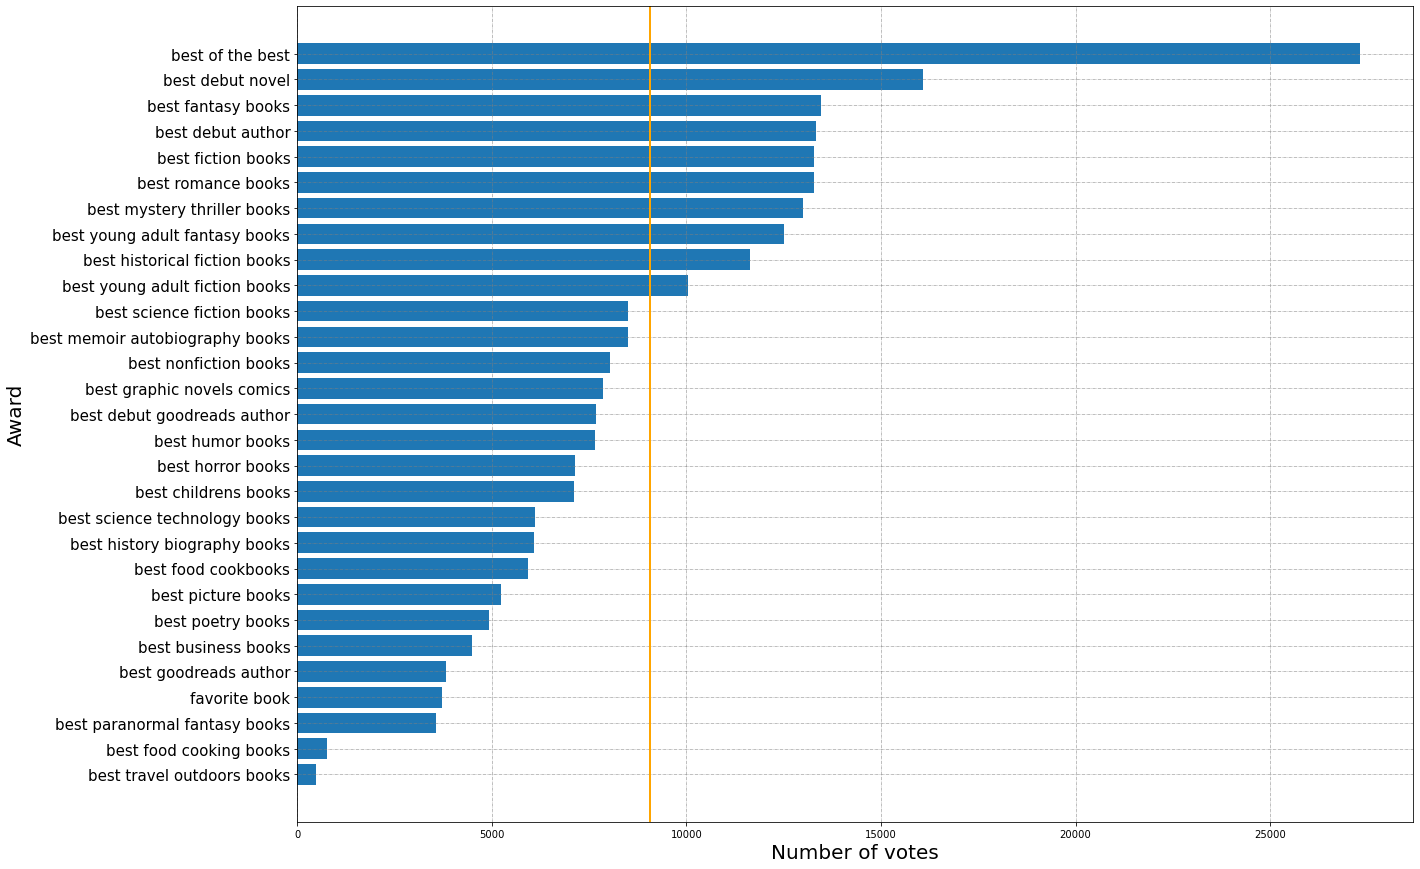

In [132]:
fig, ax = plt.subplots(figsize=(20,15))
ax.barh(df1.index, df1['number_of_votes'])
ax.grid(linestyle='-.', linewidth=0.5, color='gray')
ax.axvline(df_join['number_of_votes'].mean(), color='orange', linewidth=2)
ax.set_ylabel('Award', fontsize=20)
ax.set_xlabel('Number of votes', fontsize=20)
ax.set_yticklabels(df1.index, fontsize=15);

### <font color='brown'>What are the top books in awards that get above average total votes?

In [133]:
df2=df_join[['award', 'book_title', 'number_of_votes']]

In [134]:
df_awards_votes_above_average = df_join.groupby('award')[['number_of_votes']].mean()[df_join.groupby('award')['number_of_votes'].mean() > df_join['number_of_votes'].mean()]

In [135]:
awards_votes_above_average = df_awards_votes_above_average.sort_values('number_of_votes',ascending=False).index

In [136]:
awards_votes_above_average

Index(['best of the best', 'best debut novel', 'best fantasy books',
       'best debut author', 'best fiction books', 'best romance books',
       'best mystery thriller books', 'best young adult fantasy books',
       'best historical fiction books', 'best young adult fiction books'],
      dtype='object', name='award')

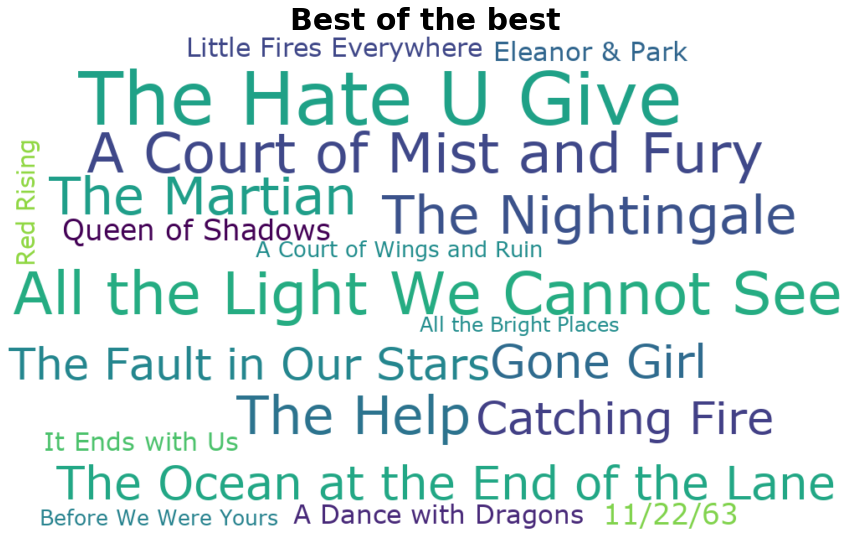

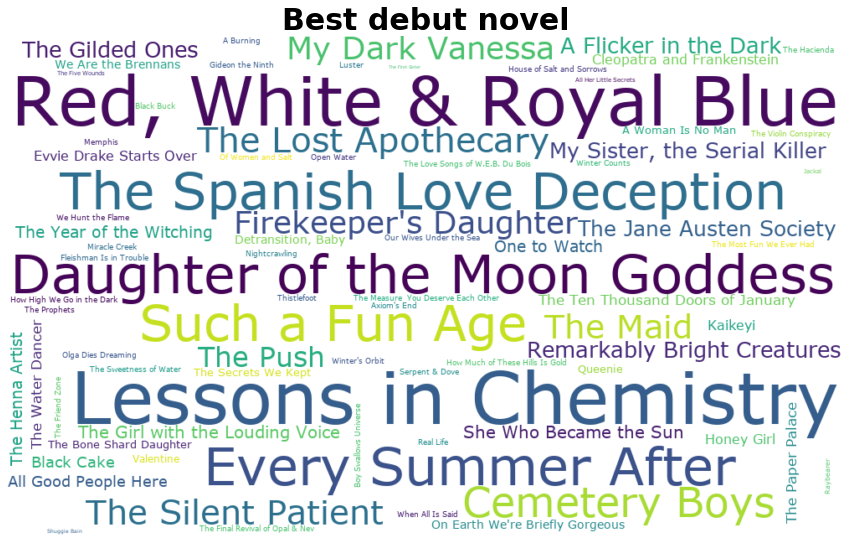

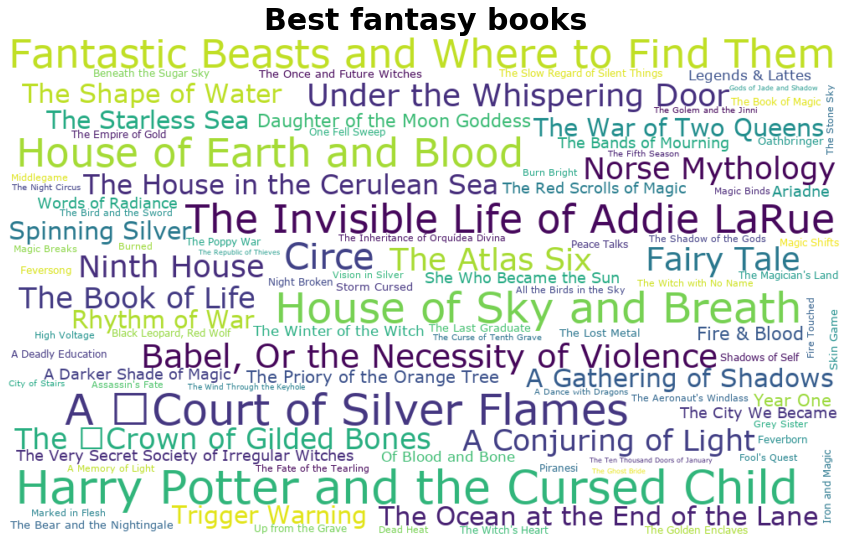

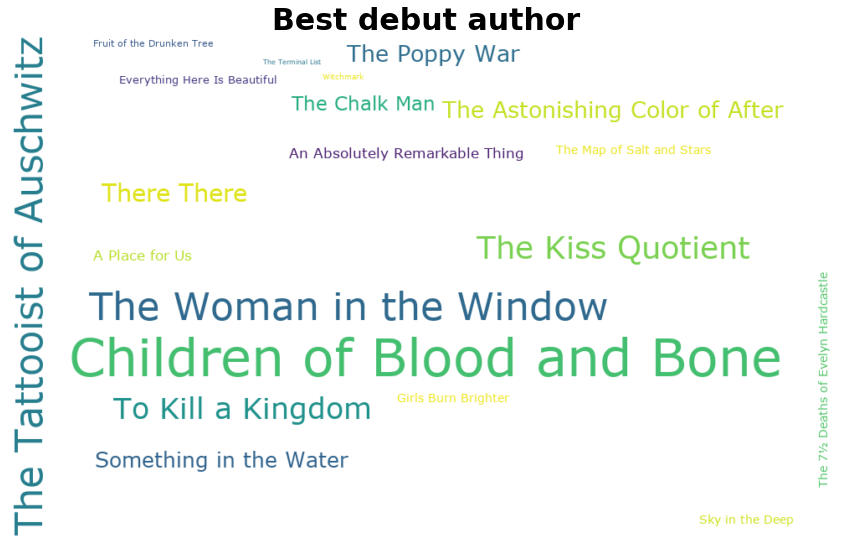

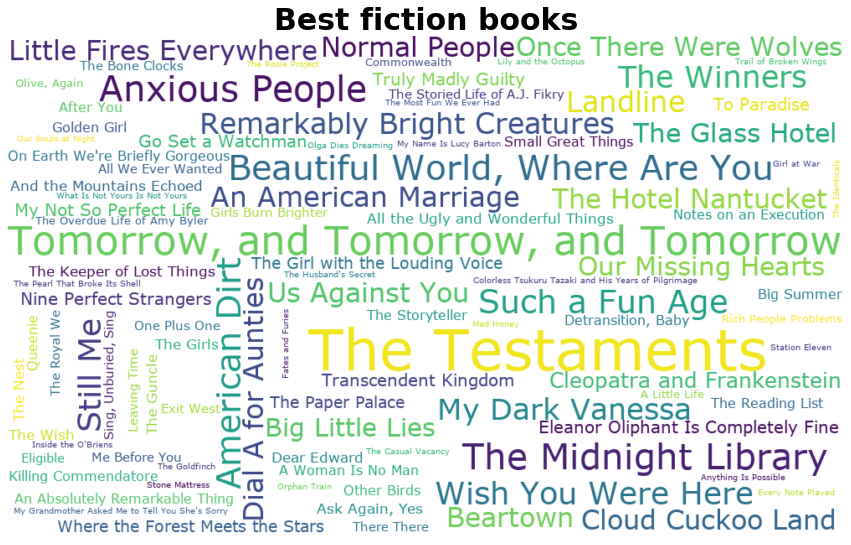

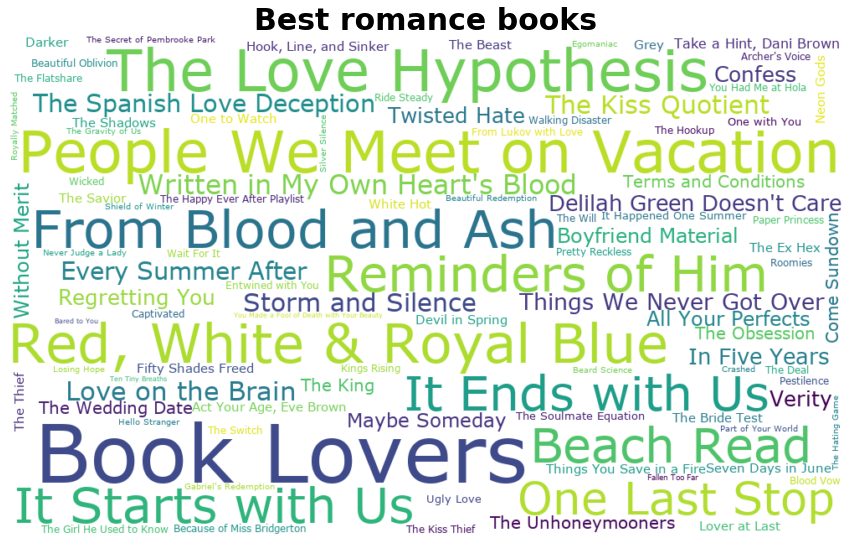

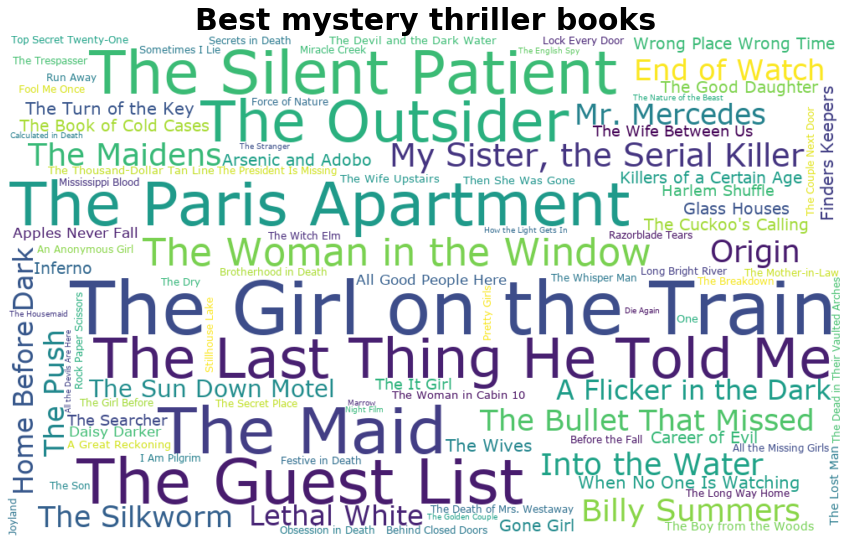

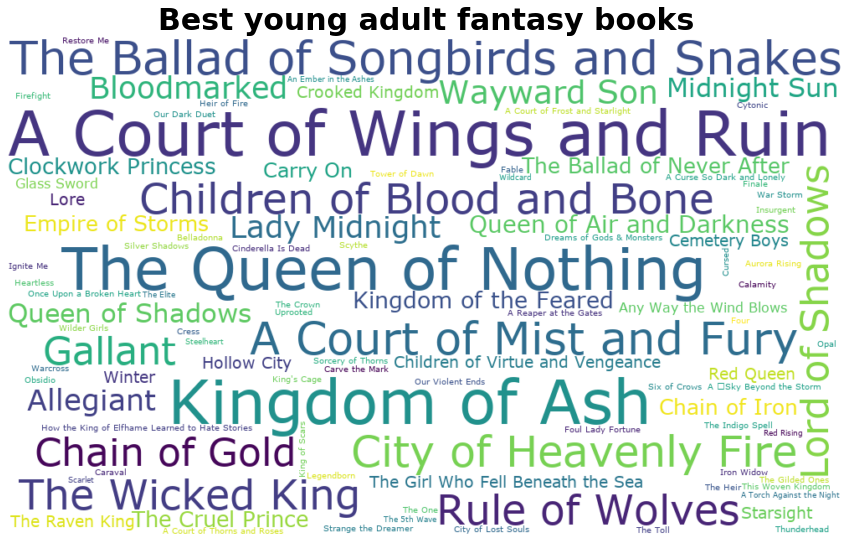

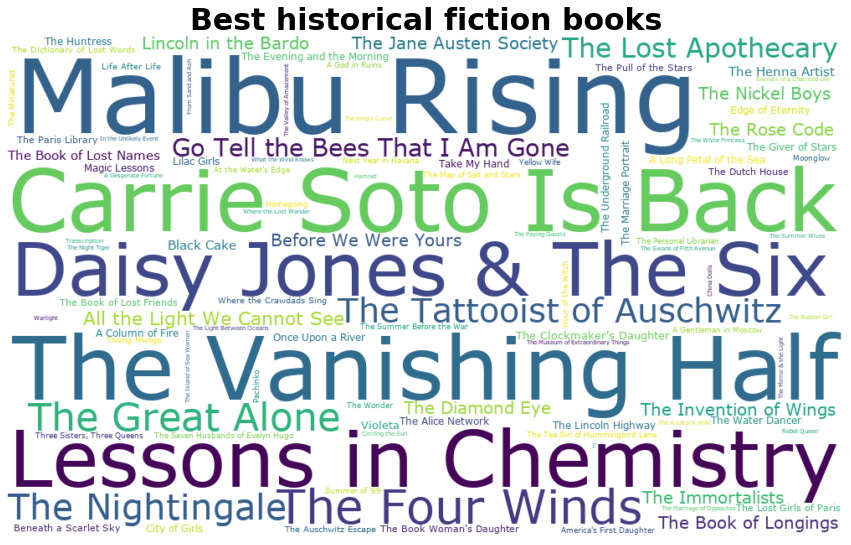

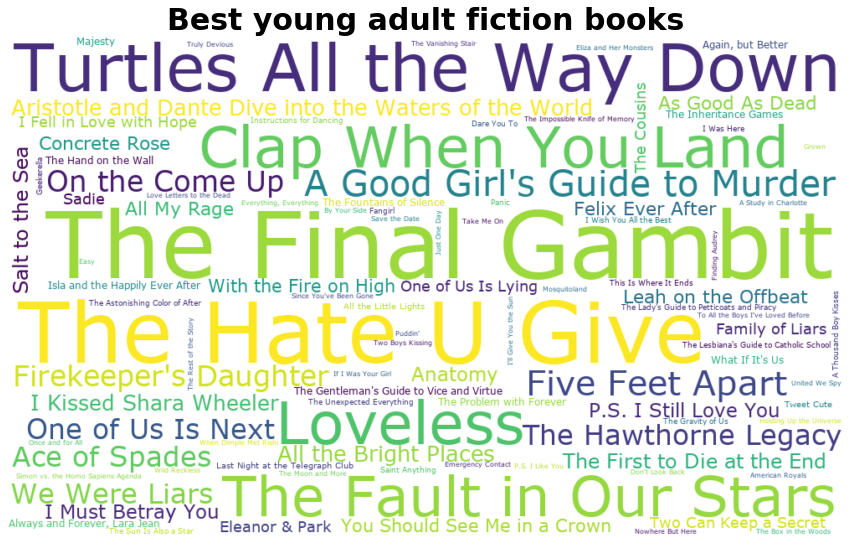

In [137]:
for award in awards_votes_above_average:
    books_vote = df2[df2['award'] == award].set_index('book_title')[['number_of_votes']].to_dict()['number_of_votes']
    wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=100, font_path='/Library/Fonts/Verdana.ttf').generate_from_frequencies(books_vote)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label=award.capitalize(), fontsize=30, weight='bold')
    plt.axis('off')
    plt.show()

### <font color='brown'>Wordcloud of books has higher ratings overall

In [138]:
df3 = df_books_detail_clean[['title','rating']].sort_values('rating', ascending=False)

In [139]:
df3_dict = df3.set_index('title').to_dict()

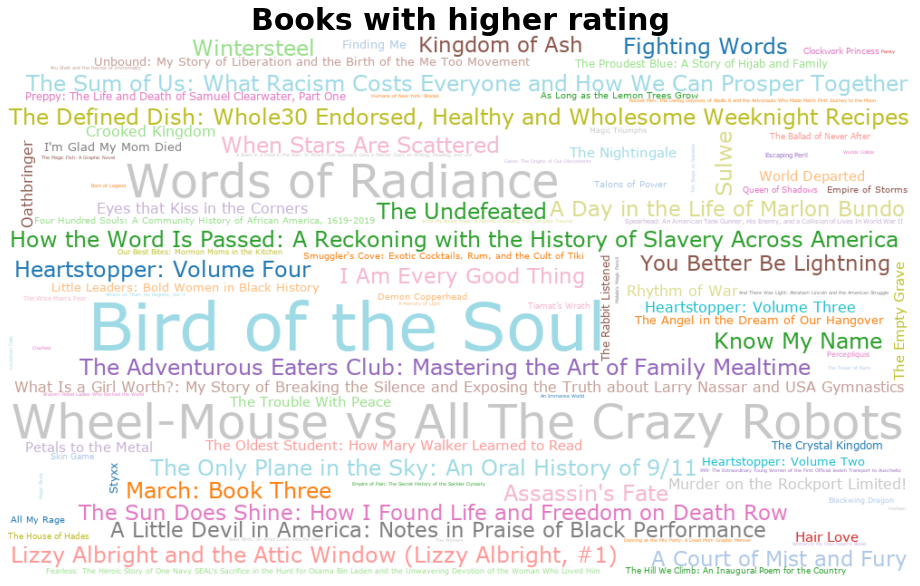

In [140]:
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=100, colormap='tab20', font_path='/Library/Fonts/Verdana.ttf').generate_from_frequencies(df3_dict['rating'])

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(label='Books with higher rating', fontsize=30, weight='bold')
plt.axis("off")
plt.show()

### <font color='brown'>Are books getting more votes also have higher ratings?

In [141]:
df4= df_join[['rating', 'number_of_votes', 'number_of_reviews']]

Text(0, 0.5, 'Number of votes')

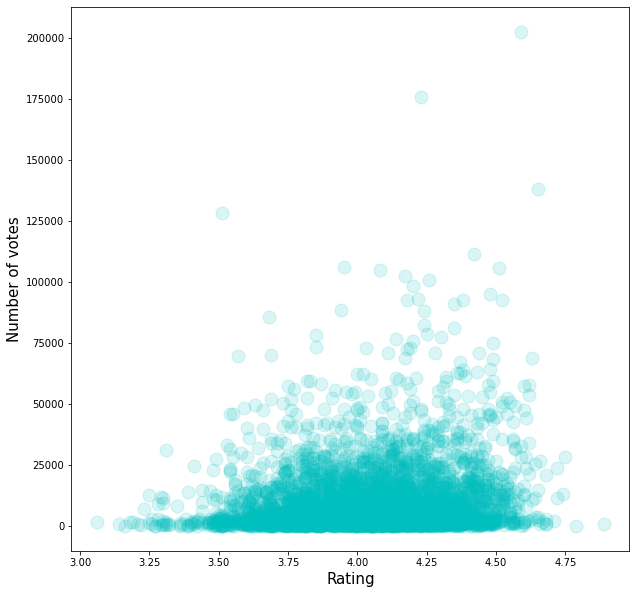

In [142]:
plt.figure(figsize=(10,10))
plt.scatter(df4['rating'], df4['number_of_votes'], s=13**2, c='c', alpha=0.15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Number of votes', fontsize=15)

### <font color='bronw'>What's the average rating of books in each award? 

In [143]:
df5 = df_join[['award', 'rating']].groupby('award').mean().sort_values('rating', ascending=True)

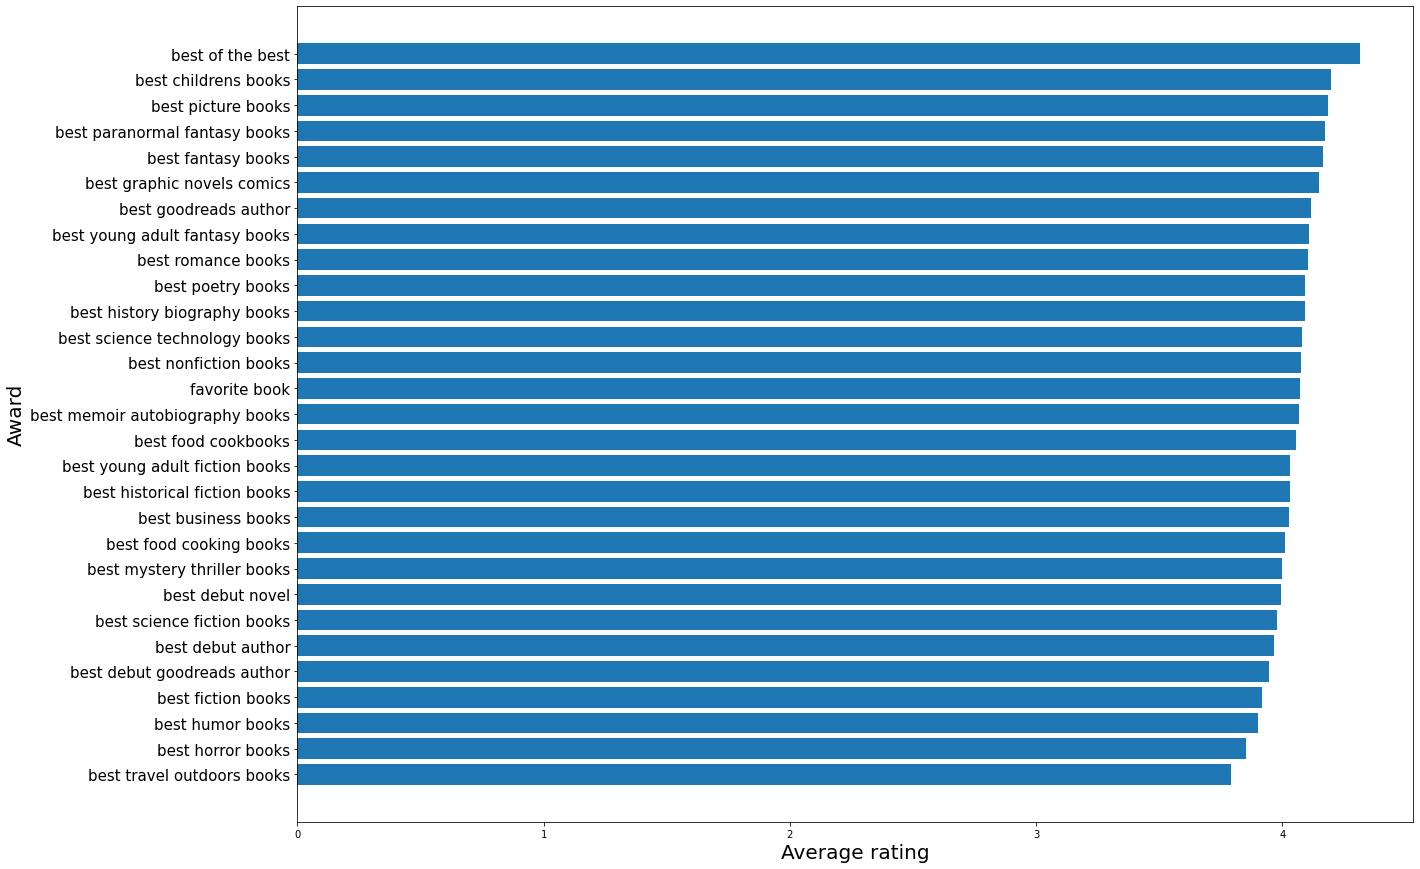

In [144]:
fig, ax = plt.subplots(figsize=(20,15))
ax.barh(df5.index, df5['rating'])
ax.set_ylabel('Award', fontsize=20)
ax.set_xlabel('Average rating', fontsize=20)
ax.set_yticklabels(df5.index, fontsize=15);